In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
beijing_pm2_5 = fetch_ucirepo(id=381)

X = beijing_pm2_5.data.features
y = beijing_pm2_5.data.targets

In [3]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from pylab import fill
import calendar

from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')

In [4]:
df = pd.concat([X, y], axis=1)

df.head()

,year,month,day,hour,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,pm2.5
0,2010,1,1,0,-21,-11.0,1021.0,NW,1.79,0,0,NaN
1,2010,1,1,1,-21,-12.0,1020.0,NW,4.92,0,0,NaN
2,2010,1,1,2,-21,-11.0,1019.0,NW,6.71,0,0,NaN
3,2010,1,1,3,-21,-14.0,1019.0,NW,9.84,0,0,NaN
4,2010,1,1,4,-20,-12.0,1018.0,NW,12.97,0,0,NaN



**Data columns**
- No: row number
- year: year of data in this row
- month: month of data in this row
- day: day of data in this row
- hour: hour of data in this row
- pm2.5: PM2.5 concentration (ug/m^3)
- DEWP: Dew Point (â„ƒ)
- TEMP: Temperature (â„ƒ)
- PRES: Pressure (hPa)
- cbwd: Combined wind direction
- Iws: Cumulated wind speed (m/s)
- Is: Cumulated hours of snow
- Ir: Cumulated hours of rain

https://royalsocietypublishing-org.remotexs.ntu.edu.sg/doi/10.1098/rspa.2015.0257


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    43824 non-null  int64  
 1   month   43824 non-null  int64  
 2   day     43824 non-null  int64  
 3   hour    43824 non-null  int64  
 4   DEWP    43824 non-null  int64  
 5   TEMP    43824 non-null  float64
 6   PRES    43824 non-null  float64
 7   cbwd    43824 non-null  object 
 8   Iws     43824 non-null  float64
 9   Is      43824 non-null  int64  
 10  Ir      43824 non-null  int64  
 11  pm2.5   41757 non-null  float64
dtypes: float64(4), int64(7), object(1)
memory usage: 4.0+ MB


In [6]:
# Rename columns to be easily recognizable
df = df.rename(columns={'DEWP': 'dew_point',
                        'PRES': 'pressure',
                        'TEMP' : 'temp',
                        'cbwd': 'wind_dir',
                        'Iws': 'wind_speed',
                        'Is':'cum_snow',
                        'Ir': 'cum_rain'
                        })

In [7]:
missing_values = df.isna().sum()

missing_values_df_eda = pd.DataFrame({'Feature': missing_values.index, 'Missing Values': missing_values.values})
missing_values_df_eda = missing_values_df_eda.sort_values(by='Missing Values', ascending=False)

missing_values_df_eda

,Feature,Missing Values
11,pm2.5,2067
0,year,0
2,day,0
1,month,0
3,hour,0
4,dew_point,0
6,pressure,0
5,temp,0
7,wind_dir,0
8,wind_speed,0


In [8]:
# drop the rows directly -> mess up the order
# first 24 rows have pm2.5 value that is NaN -> discard
# else: forward filling
df = df[24:].fillna(method='ffill')
df['pm2.5'].isna().sum()

<ipython-input-8-fdc79dbbeee5>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df[24:].fillna(method='ffill')


np.int64(0)

In [9]:
missing_values = df.isna().sum()

missing_values_df_eda = pd.DataFrame({'Feature': missing_values.index, 'Missing Values': missing_values.values})
missing_values_df_eda = missing_values_df_eda.sort_values(by='Missing Values', ascending=False)

missing_values_df_eda

,Feature,Missing Values
0,year,0
1,month,0
2,day,0
3,hour,0
4,dew_point,0
5,temp,0
6,pressure,0
7,wind_dir,0
8,wind_speed,0
9,cum_snow,0


In [10]:
df_eda = df.copy()
df_eda['dateTime'] = df_eda.apply(lambda x : datetime.datetime(year=x['year'], month=x['month'], day=x['day'], hour=x['hour']), axis=1)
df_eda.drop(columns=['year', 'month', 'day', 'hour'], inplace=True)
df_eda = df_eda.set_index('dateTime')
df_eda.head()

,dew_point,temp,pressure,wind_dir,wind_speed,cum_snow,cum_rain,pm2.5
dateTime,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,SE,1.79,0,0,129.0
2010-01-02 01:00:00,-15,-4.0,1020.0,SE,2.68,0,0,148.0
2010-01-02 02:00:00,-11,-5.0,1021.0,SE,3.57,0,0,159.0
2010-01-02 03:00:00,-7,-5.0,1022.0,SE,5.36,1,0,181.0
2010-01-02 04:00:00,-7,-5.0,1022.0,SE,6.25,2,0,138.0


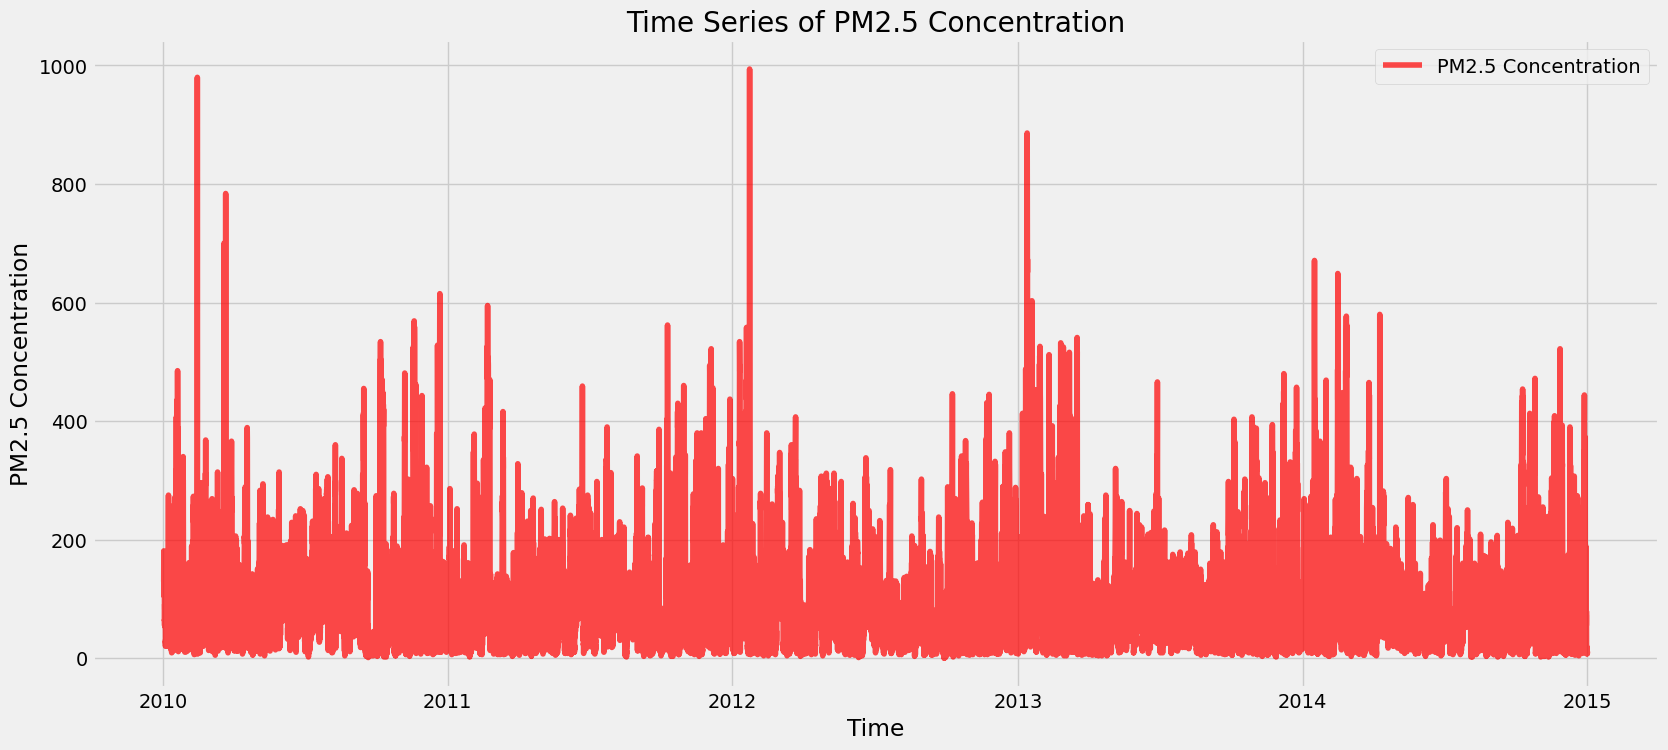

In [11]:
# Plot the time series
plt.plot(df_eda.index, df_eda['pm2.5'], color='red', alpha=0.7, label="PM2.5 Concentration")

# Formatting
plt.xlabel("Time")
plt.ylabel("PM2.5 Concentration")
plt.title("Time Series of PM2.5 Concentration")
plt.legend()
plt.grid(True)
plt.show()

- The plot shows consistent variation in PM2.5 levels over time.
- There are periods of low PM2.5 followed by extreme increases.
- Early 2010, late 2012 and early 2013 appear to have higher pollution periods

## Rolling Averages

In [12]:
df_eda_rolling = df_eda.copy()

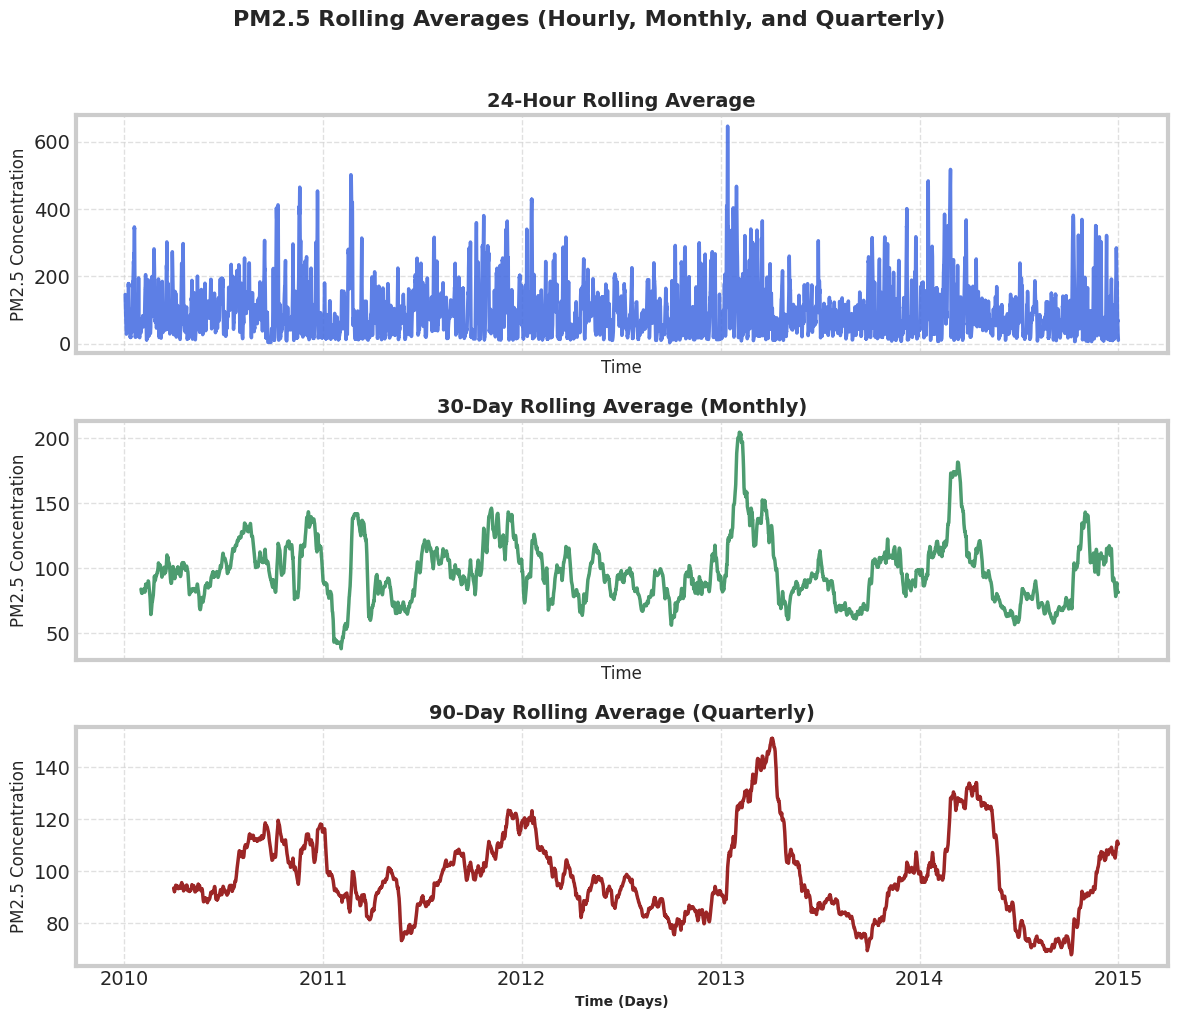

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean seaborn style
sns.set_style("whitegrid")

# Ensure datetime index
df_eda_rolling.index = pd.to_datetime(df_eda_rolling.index)

# Compute rolling averages
df_eda_rolling['pm2.5_rolling_24h'] = df_eda_rolling['pm2.5'].rolling(window=24).mean()   # 24-hour rolling avg
df_eda_rolling['pm2.5_rolling_month'] = df_eda_rolling['pm2.5'].rolling(window=30*24).mean()  # 30-day rolling avg
df_eda_rolling['pm2.5_rolling_quarter'] = df_eda_rolling['pm2.5'].rolling(window=90*24).mean()  # 90-day rolling avg

# Create a larger figure with 3 subplots (1 column)
fig, axarr = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Define rolling averages and titles
rolling_averages = [
    ('pm2.5_rolling_24h', "24-Hour Rolling Average", 'royalblue'),
    ('pm2.5_rolling_month', "30-Day Rolling Average (Monthly)", 'seagreen'),
    ('pm2.5_rolling_quarter', "90-Day Rolling Average (Quarterly)", 'darkred'),
]

# Plot each rolling average
for ax, (col, title, color) in zip(axarr, rolling_averages):
    ax.plot(df_eda_rolling.index, df_eda_rolling[col], color=color, linewidth=2.5, alpha=0.85)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel("PM2.5 Concentration", fontsize=12)
    ax.set_xlabel("Time", fontsize=12)  # Ensure x-labels on all subplots
    ax.grid(True, linestyle='--', alpha=0.6)

# Improve x-axis readability
axarr[-1].set_xlabel("Time (Days)", fontsize=10, fontweight='bold')

# Add a suptitle
plt.suptitle("PM2.5 Rolling Averages (Hourly, Monthly, and Quarterly)", fontsize=16, fontweight='bold', y=1.02)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

From the 90-Day rolling average graph, most peaks seem to happen at the start and end of the year with a drop in the middle of the year.

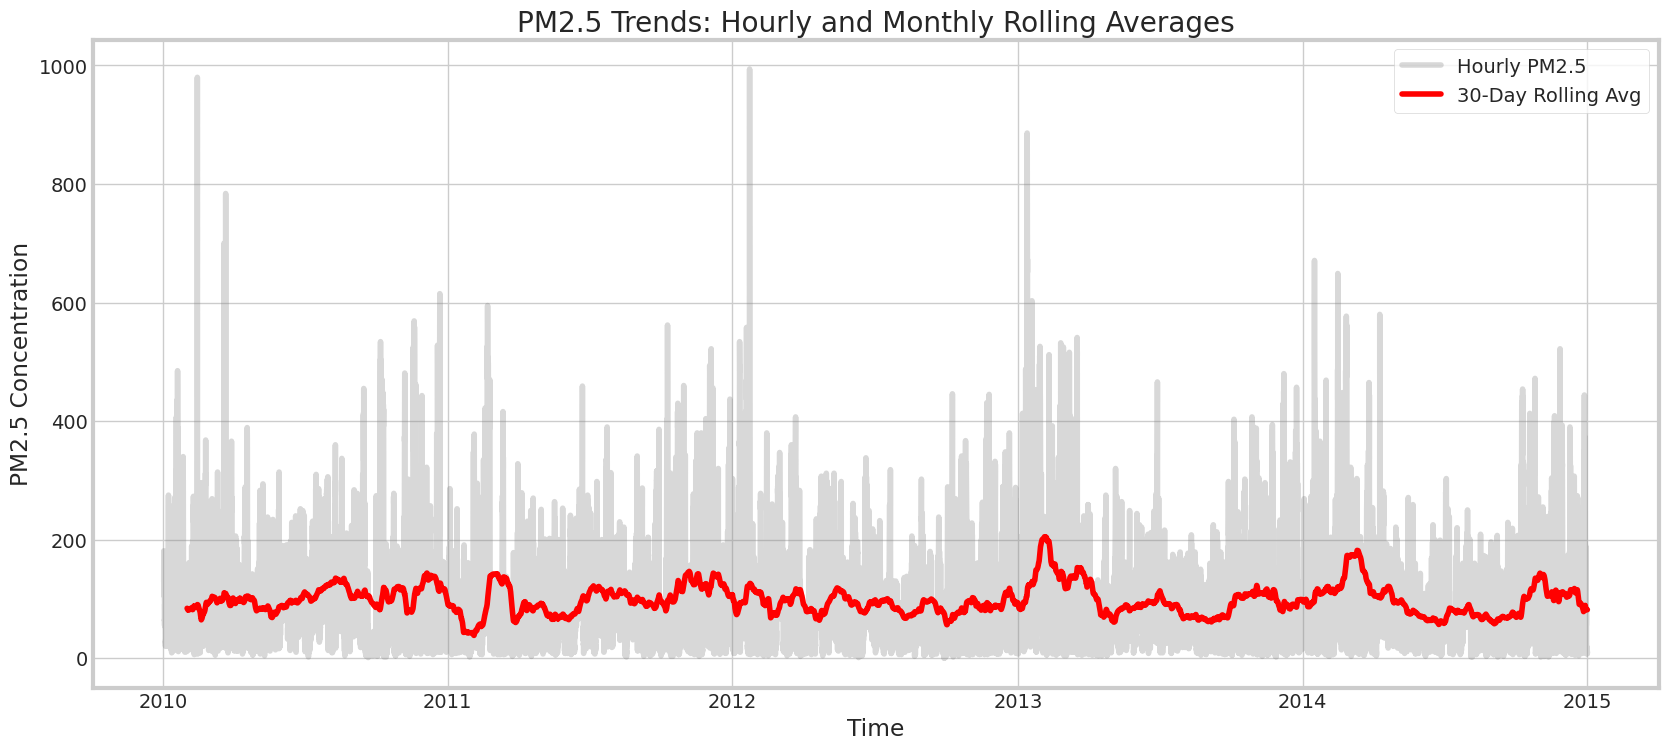

In [14]:
# Monthly (30-day) rolling average
df_eda_rolling['pm2.5_rolling_month'] = df_eda_rolling['pm2.5'].rolling(window=720).mean()

# Plot original PM2.5 data (lighter color for reference)
plt.plot(df_eda_rolling.index, df_eda_rolling['pm2.5'], alpha=0.3, label="Hourly PM2.5", color='gray')

# Plot the 30-day rolling average
plt.plot(df_eda_rolling.index, df_eda_rolling['pm2.5_rolling_month'], label="30-Day Rolling Avg", color='red')

# Formatting
plt.xlabel("Time")
plt.ylabel("PM2.5 Concentration")
plt.title("PM2.5 Trends: Hourly and Monthly Rolling Averages")
plt.legend()
plt.grid(True)
plt.show()

## Compare Seasonal Trends

In [15]:
df_eda_season = df_eda.copy()

# Define seasons (Winter: Dec-Feb, Spring: Mar-May, Summer: Jun-Aug, Fall: Sep-Nov)
df_eda_season['season'] = df_eda_season.index.month.map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Compute seasonal averages
seasonal_pm25 = df_eda_season.groupby('season')['pm2.5'].mean().reindex(['Winter', 'Spring', 'Summer', 'Fall'])

df_eda_season.head()

,dew_point,temp,pressure,wind_dir,wind_speed,cum_snow,cum_rain,pm2.5,season
dateTime,,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,SE,1.79,0,0,129.0,Winter
2010-01-02 01:00:00,-15,-4.0,1020.0,SE,2.68,0,0,148.0,Winter
2010-01-02 02:00:00,-11,-5.0,1021.0,SE,3.57,0,0,159.0,Winter
2010-01-02 03:00:00,-7,-5.0,1022.0,SE,5.36,1,0,181.0,Winter
2010-01-02 04:00:00,-7,-5.0,1022.0,SE,6.25,2,0,138.0,Winter


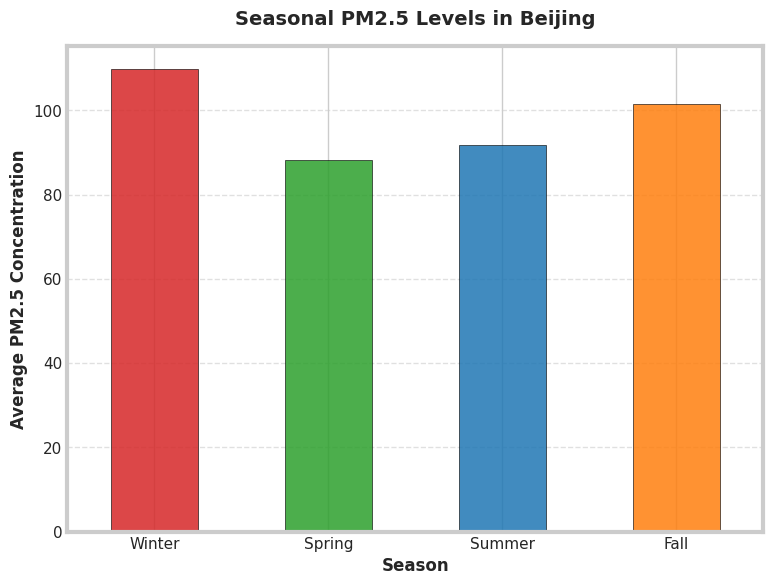

In [16]:
# Define custom colors for seasons
season_colors = ['#D62728', '#2CA02C', '#1F77B4', '#FF7F0E']  # Red, Green, Blue, Orange

# Create the bar plot with enhancements
plt.figure(figsize=(8, 6))
seasonal_pm25.plot(
    kind='bar',
    color=season_colors,
    edgecolor='black',
    alpha=0.85  # Slight transparency for a softer look
)

# Add labels and title
plt.ylabel("Average PM2.5 Concentration", fontsize=12, fontweight='bold')
plt.xlabel("Season", fontsize=12, fontweight='bold')
plt.title("Seasonal PM2.5 Levels in Beijing", fontsize=14, fontweight='bold', pad=15)

# Improve x-axis visibility
plt.xticks(rotation=0, fontsize=11)
plt.yticks(fontsize=11)

# Add grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Display the plot
plt.show()


## Analyze Weather Impact


In [17]:
df_eda_weather = df_eda.copy()

In [18]:
# One-Hot encoding for 'cbwd' (Wind Direction)
df_eda_weather = df_eda_weather.join(pd.get_dummies(df_eda_weather['wind_dir']).astype(int))  # Convert True/False to 0/1
df_eda_weather.drop(columns=['wind_dir'], inplace=True)  # Remove the original categorical column

df_eda_weather.head()

,dew_point,temp,pressure,wind_speed,cum_snow,cum_rain,pm2.5,NE,NW,SE,cv
dateTime,,,,,,,,,,,
2010-01-02 00:00:00,-16,-4.0,1020.0,1.79,0,0,129.0,0,0,1,0
2010-01-02 01:00:00,-15,-4.0,1020.0,2.68,0,0,148.0,0,0,1,0
2010-01-02 02:00:00,-11,-5.0,1021.0,3.57,0,0,159.0,0,0,1,0
2010-01-02 03:00:00,-7,-5.0,1022.0,5.36,1,0,181.0,0,0,1,0
2010-01-02 04:00:00,-7,-5.0,1022.0,6.25,2,0,138.0,0,0,1,0


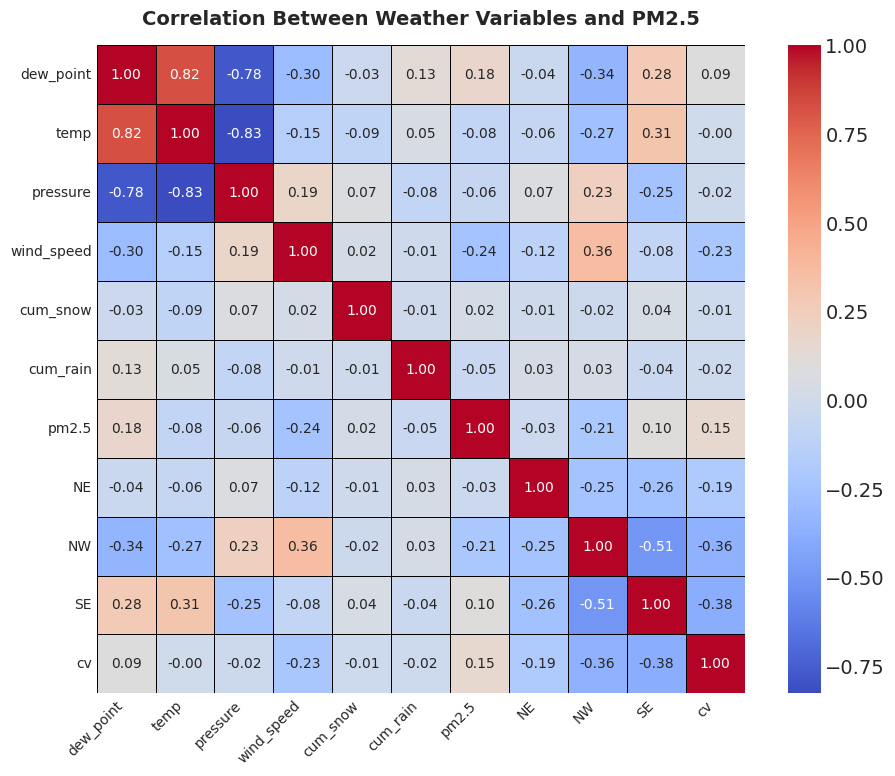

In [19]:
# Compute Correlations
correlation_matrix = df_eda_weather.corr()

# Set up the figure size and styling
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")

# Plot Correlation Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5,
            cbar=True, square=True, annot_kws={"size": 10}, linecolor='black')

# Title and formatting
plt.title("Correlation Between Weather Variables and PM2.5", fontsize=14, fontweight='bold', pad=15)
plt.xticks(fontsize=10, rotation=45, ha='right')
plt.yticks(fontsize=10, rotation=0)

# Show plot
plt.show()

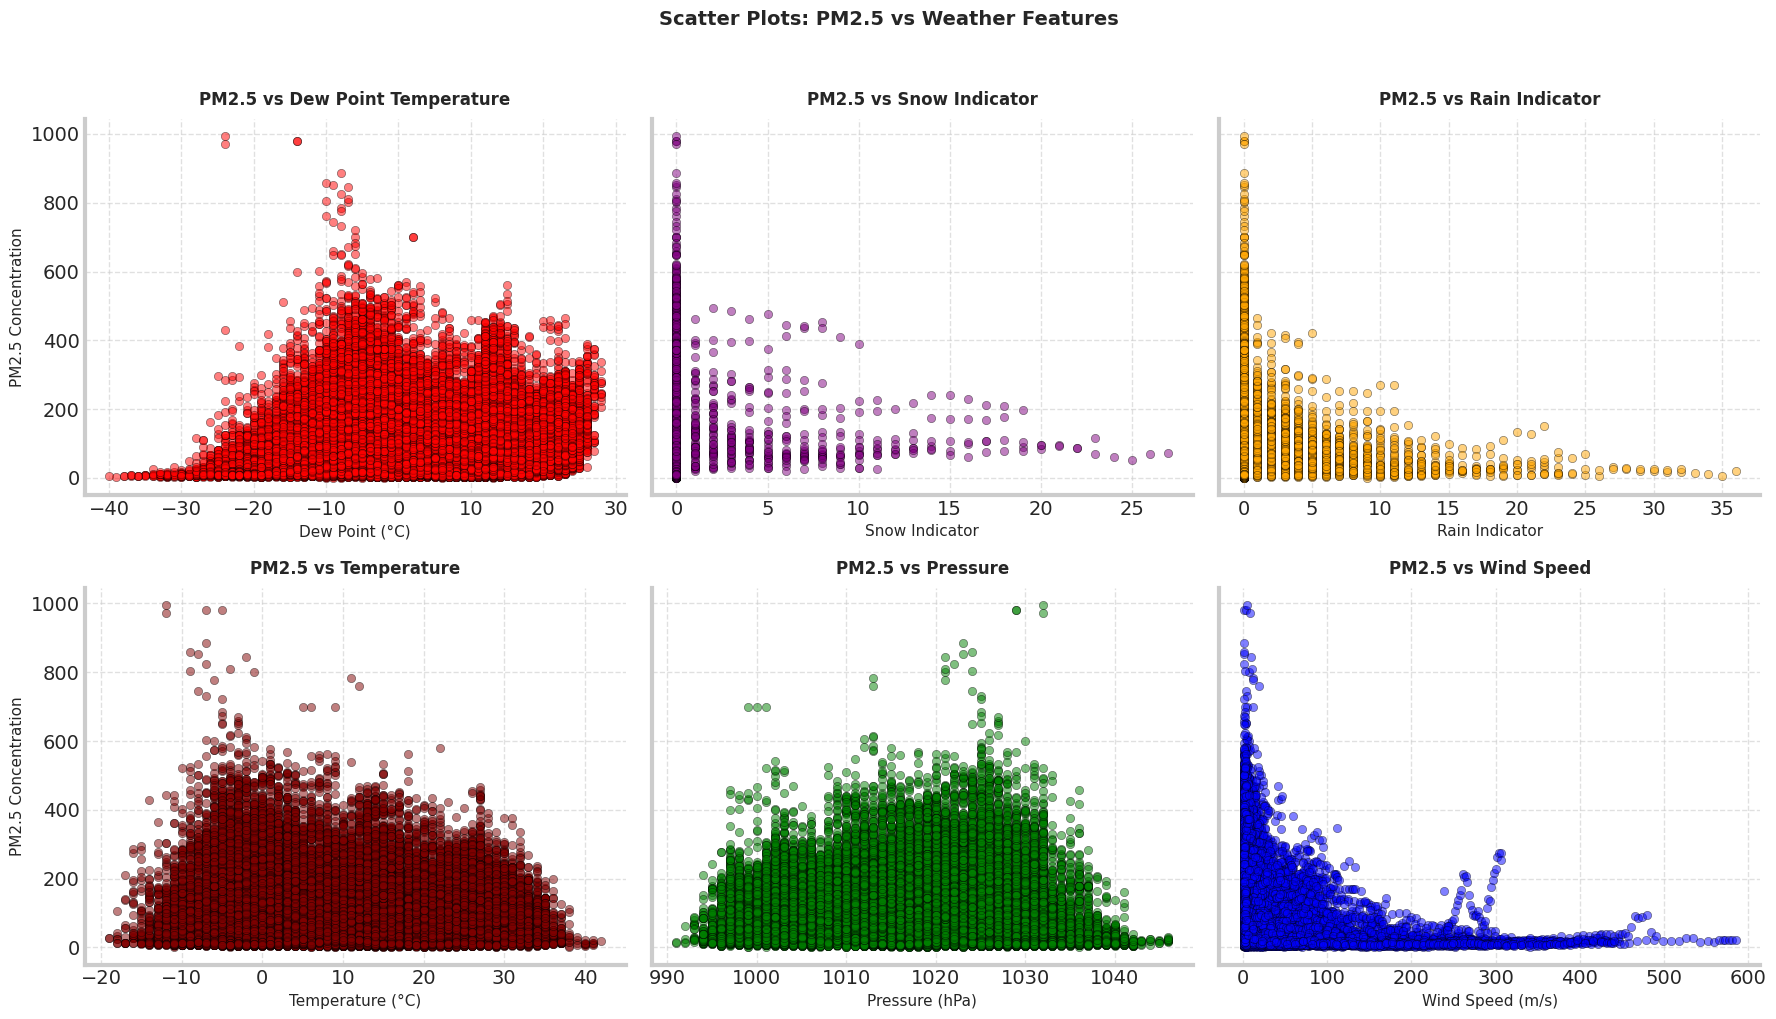

In [20]:
# Feature pairs for plotting
feature_pairs = [
    ('dew_point', 'PM2.5 vs Dew Point Temperature', 'Dew Point (°C)', 'red'),
    ('cum_snow', 'PM2.5 vs Snow Indicator', 'Snow Indicator', 'purple'),
    ('cum_rain', 'PM2.5 vs Rain Indicator', 'Rain Indicator', 'orange'),
    ('temp', 'PM2.5 vs Temperature', 'Temperature (°C)', 'maroon'),
    ('pressure', 'PM2.5 vs Pressure', 'Pressure (hPa)', 'green'),
    ('wind_speed', 'PM2.5 vs Wind Speed', 'Wind Speed (m/s)', 'blue')
]

# Set up 2x3 subplots with increased figure size and styling
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=False)
sns.set_style("whitegrid")

# Iterate over feature pairs to plot scatter plots
for i, (feature, title, xlabel, color) in enumerate(feature_pairs):
    row, col = divmod(i, 3)  # Convert index to (row, col) for 2x3 layout
    ax = axes[row, col]

    # Create scatter plot
    sns.scatterplot(x=df_eda_weather[feature], y=df_eda_weather['pm2.5'], alpha=0.5, ax=ax, color=color, edgecolor="black")

    # Titles and labels
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel("PM2.5 Concentration", fontsize=11)

    # Grid and aesthetics
    ax.grid(True, linestyle="--", alpha=0.6)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

# Adjust layout for better readability
plt.suptitle("Scatter Plots: PM2.5 vs Weather Features", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

1. PM2.5 vs Dew Point Temperature
  - PM2.5 increases as dew point rises from -40°C to around 10°C, then slightly decreases.
  - Very low dew points (cold, dry air) show lower PM2.5
  - Conclusion: High humidity may contribute to higher pollution levels.

2. PM2.5 vs Snow Indicator
  - PM2.5 concentration decreases as snowfall increases.
  - Higher PM2.5 values appear mostly when snow is minimal or absent.
  - Conclusion: Snowfall likely improves air quality by reducing PM2.5 levels.

3. PM2.5 vs Rain Indicator
  - Higher rain values correlate with lower PM2.5.
  - Heavier rainfall events correlate with very low PM2.5 level
  - Conclusion: Rain significantly reduces air pollution, confirming its role in natural air purification.

4. PM2.5 vs Temperature
  - PM2.5 is highest in cold temperatures (below 10°C) and decreases at higher temperatures (above 20°C).
  - Conclusion: Cold temperatures worsen air quality, while warm temperatures improve it.
5. PM2.5 vs Pressure
  - PM2.5 peaks around mid-range pressures (1010–1025 hPa) and decreases at very high or low pressures.
  - Stable weather conditions with moderate pressure tend to correlate with higher pollution levels.
  - Conclusion: High-pressure, stable weather contributes to increased pollution.
6. PM2.5 vs Wind Speed
  - Trend: PM2.5 is highest at very low wind speeds and drops sharply as wind speed increases.
  - Outliers may represent extreme weather events or measurement anomalies.

In [22]:
df_eda_wind = df_eda.copy()

<ipython-input-24-0d56ff5f59df>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


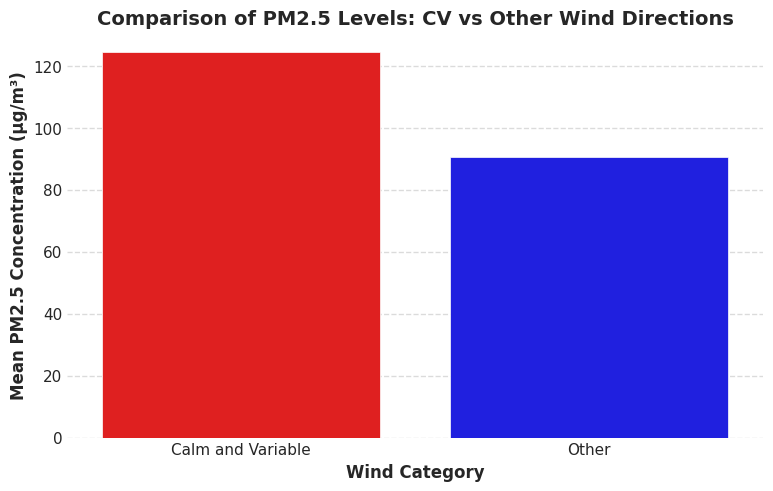

In [24]:
# Group wind directions into two categories
df_eda_wind['wind_category'] = df_eda_wind['wind_dir'].apply(lambda x: 'Calm and Variable' if x == 'cv' else 'Other')

# Compute Mean PM2.5 for Each Wind Category
mean_pm25_by_wind_category = df_eda_wind.groupby('wind_category')['pm2.5'].mean()

# Plot the bar chart
plt.figure(figsize=(8, 5))
sns.barplot(
    x=mean_pm25_by_wind_category.index,
    y=mean_pm25_by_wind_category.values,
    palette=['red', 'blue']
)

# Customize labels and title
plt.xlabel("Wind Category", fontsize=12, fontweight='bold')
plt.ylabel("Mean PM2.5 Concentration (µg/m³)", fontsize=12, fontweight='bold')
plt.title("Comparison of PM2.5 Levels: CV vs Other Wind Directions", fontsize=14, fontweight='bold')

# Improve readability
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.box(False)  # Remove plot border for cleaner look

# Show the plot
plt.show()

In [ ]:
# Create subplots (7 rows, 1 column)
fig, axarr = plt.subplots(7, 1, figsize=(30, 20), sharex=True)  # Share x-axis for better alignment

# Define labels for each subplot
features = ['pm2.5', 'dew_point', 'temp', 'pressure', 'wind_speed', 'cum_snow', 'cum_rain',]
titles = ['PM2.5 Concentration', 'Dew Point Temperature', 'Temperature',
          'Pressure', 'Wind Speed', 'Snow Indicator', 'Rain Indicator']

# Plot each feature with labels
for i, feature in enumerate(features):
    axarr[i].plot(df_eda.index, df_eda[feature], label=feature, color='b' if i == 0 else 'r')
    axarr[i].set_ylabel(feature, fontsize=14)  # Y-axis label
    axarr[i].set_title(titles[i], fontsize=16)  # Title
    axarr[i].grid(True, linestyle="--", alpha=0.5)  # Add grid lines
    axarr[i].legend(loc="upper right")  # Add legend

# Add X-axis label to the last subplot
axarr[-1].set_xlabel("Time", fontsize=14)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

## Visualizing how PM 2.5 levels vary across different months in Beijing for each year

In [ ]:
df_eda_2 = df.copy()
df_eda_2['Date'] = pd.to_datetime(df[['year','month','day','hour']])
df_eda_2.set_index('Date', inplace=True)  # Set Date as index
df_eda_2 = df_eda_2[['pm2.5', 'month']]
df_eda_weather = df_eda_2.resample('D').mean()

In [ ]:
# Generate a simple scatter plot of daily mean PM2.5 concentration for entire time span
scatter_y = df_eda_weather['pm2.5'].resample('D').mean()
scatter_x = df_eda_weather['pm2.5'].resample('D').mean().index

plt.scatter(x = scatter_x, y = scatter_y, alpha = 0.4)
plt.xlabel('Year')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality, 2010-2015')
plt.show()

In [ ]:
# Distribution of air quality for the period 2010-2015
plt.hist(scatter_y.dropna(), bins = 20, edgecolor='w', lw=1)
plt.xlabel('Daily Average PM 2.5 Concentration (μg/m3)')
plt.ylabel('Frequency')
plt.title('Distribution of Air Quality')
plt.text(110, 430, 'Mean = ' + str(round(scatter_y.dropna().mean(),2)), color = 'red')
plt.text(-53, 430, 'Median = ' + str(round(scatter_y.dropna().median(),2)), color = 'green')
plt.axvline(scatter_y.dropna().mean(), color='r', linestyle='dashed', linewidth=2)
plt.axvline(scatter_y.dropna().median(), color='g', linestyle='dashed', linewidth=2)
plt.show()

In [ ]:
# Plot PM 2.5 level by MONTH
sns.boxplot(x='month', y='pm2.5', data=df_eda_2, palette="Set2", showfliers=False)
plt.xlabel('Month')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Month')
plt.xticks(range(0,12), calendar.month_abbr[1:13])
plt.show()

In [ ]:
# Plot PM 2.5 level by DAY OF THE WEEK
weekday = []
df_eda_2["weekday"] = df_eda_2.index.weekday

sns.boxplot(x="weekday", y="pm2.5", data=df_eda_2, palette="Set2",showfliers=False)
plt.xlabel('Day of the Week')
plt.ylabel('PM 2.5 Concentration (μg/m3)')
plt.title('Air Quality by Day of the Week')
plt.xticks(range(0,7), calendar.day_name)
plt.show()

In [ ]:
fig, ax = plt.subplots()
sns.lineplot(x = 'month', y = 'pm2.5', hue=df_eda_weather.index.year, data = df_eda_weather);
ax.set(xlabel='Month',
       ylabel='Measured PM 2.5 (μm/m^3)',
       title='PM 2.5 (μm/m^3) by Month in Beijing',
       xlim=[1, 12],ylim=[30,300])
plt.show()

In [ ]:
fig, ax = plt.subplots()

# Line plot of PM 2.5 across months
sns.lineplot(x='month', y='pm2.5', data=df_eda_weather, ax=ax)

ax.set(xlabel='Month',
       ylabel='Measured PM 2.5 (μm/m³)',
       title='PM 2.5 (μm/m³) by Month in Beijing',
       xlim=[1, 12], ylim=[0, 175])

plt.xticks(size=10)
plt.yticks(size=10)

# Using plt.fill() (from pylab) to create shaded AQI bands
plt.fill([0, 12, 12, 0], [0, 0, 50, 50], color='green', alpha=0.3, ec='r')
plt.fill([0, 12, 12, 0], [50, 50, 100, 100], color='yellow', alpha=0.3, ec='r')
plt.fill([0, 12, 12, 0], [100, 100, 150, 150], color='#ff6500', alpha=0.3, ec='r')
plt.fill([0, 12, 12, 0], [150, 150, 200, 200], color='red', alpha=0.3, ec='r')
plt.fill([0, 12, 12, 0], [200, 200, 300, 300], color='purple', alpha=0.3, ec='r')
plt.fill([0, 12, 12, 0], [300, 300, 500, 500], color='brown', alpha=0.3, ec='r')

# Adjusted Annotations for AQI Ranges
# ax.annotate('Hazardous (300-500)', color='k',
#             xy=(6, 400), xycoords='data',  # Adjusted xy to place text in the middle
#             horizontalalignment='center', verticalalignment='center')

# ax.annotate('Very Unhealthy (200-300)', color='k',
#             xy=(6, 250), xycoords='data',
#             horizontalalignment='center', verticalalignment='center')

ax.annotate('Unhealthy (150-200)', color='k',
            xy=(11, 165), xycoords='data',
            horizontalalignment='center', verticalalignment='center')

ax.annotate('Unhealthy to Sensitive Groups (100-150)', color='k',
            xy=(10.5, 140), xycoords='data',
            horizontalalignment='center', verticalalignment='center')

ax.annotate('Moderate (50-100)', color='k',
            xy=(11, 75), xycoords='data',
            horizontalalignment='center', verticalalignment='center')

ax.annotate('Good (0-50)', color='k',
            xy=(11, 25), xycoords='data',
            horizontalalignment='center', verticalalignment='center')

plt.show()



We compared monthly and split the graph by hazard levels of the PM 2.5 levels. It seems Beijing spends most of it's time in the "Unhealthy" catergory, expecially in Q4 where there may be more holidays and travel contributing to the high levels of particulate matter.

https://aqicn.org/city/beijing/